In [4]:
import numpy as np
from skimage import img_as_ubyte
from skimage.io import imread, imsave
from matplotlib import pyplot as plt

In [91]:
def compute_mse(img_1, img_2):
    assert img_1.shape == img_2.shape
    return ((img_1 - img_2) ** 2).sum() / (img_1.shape[0] * img_1.shape[1])


def compute_ncc(img_1, img_2):
    assert img_1.shape == img_2.shape
    return (img_1 * img_2).sum() / np.sqrt((img_1 ** 2).sum() + (img_2 ** 2).sum())


def compute_colored_img(raw_img):
    h = raw_img.shape[0] // 3
    return np.stack((raw_img[2*h:3*h, :], raw_img[h:2*h, :], raw_img[0:h, :])).transpose(1, 2, 0), h


def crop_colored_img(colored_img):
    k = 0.07
    cr = int(k * colored_img.shape[0]), int(k * colored_img.shape[1])
    return colored_img[cr[0]:-cr[0], cr[1]:-cr[1], :]

def align_two(img_1, img_2, shift):
    if shift == (0, 0):
        return img_1, img_2
    if shift[0] == 0:
        if shift[1] > 0:
            return img_1[:, shift[1]:], img_2[:, :-shift[1]]
        else:
            return img_1[:, :shift[1]], img_2[:, -shift[1]:]
    if shift[1] == 0:
        if shift[0] > 0:
            return img_1[shift[0]:, :], img_2[:-shift[0], :]
        else:
            return img_1[:shift[0], :], img_2[-shift[0]:, :]
    
    return align_two(*align_two(img_1, img_2, shift=(shift[0], 0)), shift=(0, shift[1]))

def compute_shifts(shift_range):
    xv, yv = np.meshgrid(np.arange(-shift_range, shift_range), np.arange(-shift_range, shift_range))
    return np.stack((xv.ravel(), yv.ravel())).T

def compute_mse_with_shift(img_1, img_2, shift):
    shifted_1, shifted_2 = align_two(img_1, img_2, shift)
    return compute_mse(shifted_1, shifted_2)

def compute_ncc_with_shift(img_1, img_2, shift):
    shifted_1, shifted_2 = align_two(img_1, img_2, shift)
    return compute_ncc(shifted_1, shifted_2)

def colored_by_shift(g, b, r, bs, rs):
    return np.stack((np.roll(r, rs, axis=(0, 1)), g, np.roll(b, bs, axis=(0, 1)))).transpose((1, 2, 0))

def int_mul_tuple(n, tup):
    return n * tup[0], n * tup[1]

def align(img, g_coord):
    #img = (img * 255).astype('uint8')
    
    colored_img, h = compute_colored_img(img)
    cropped_img = crop_colored_img(colored_img)
    
    if cropped_img.shape[0] < 500:
        print('small')
        shifts = compute_shifts(15)

        best_r_shift = shifts[np.array([compute_mse_with_shift(cropped_img[:, :, 1], cropped_img[:, :, 0], tuple(shift)) for shift in shifts]).argmin()]
        best_b_shift = shifts[np.array([compute_mse_with_shift(cropped_img[:, :, 1], cropped_img[:, :, 2], tuple(shift)) for shift in shifts]).argmin()]
    
    else:
        print('big')
        #best_b_shift = gs['b']
        #best_r_shift = gs['r']
        
        cropped_img_8 = cropped_img[::8, ::8, :]
        shifts_8 = compute_shifts(15)
        r_shift_8 = shifts_8[np.array([compute_mse_with_shift(cropped_img_8[:, :, 1], cropped_img_8[:, :, 0], tuple(shift)) for shift in shifts_8]).argmin()]
        b_shift_8 = shifts_8[np.array([compute_mse_with_shift(cropped_img_8[:, :, 1], cropped_img_8[:, :, 2], tuple(shift)) for shift in shifts_8]).argmin()]
        
        cropped_img_4 = cropped_img[::4, ::4, :]
        shifts_4_r = compute_shifts(5) + int_mul_tuple(2, r_shift_8)
        shifts_4_b = compute_shifts(5) + int_mul_tuple(2, b_shift_8)
        r_shift_4 = shifts_4_r[np.array([compute_mse_with_shift(cropped_img_4[:, :, 1], cropped_img_4[:, :, 0], tuple(shift)) for shift in shifts_4_r]).argmin()]
        b_shift_4 = shifts_4_b[np.array([compute_mse_with_shift(cropped_img_4[:, :, 1], cropped_img_4[:, :, 2], tuple(shift)) for shift in shifts_4_b]).argmin()]
        
        cropped_img_2 = cropped_img[::2, ::2, :]
        shifts_2_r = compute_shifts(5) + int_mul_tuple(2, r_shift_4)
        shifts_2_b = compute_shifts(5) + int_mul_tuple(2, b_shift_4)
        r_shift_2 = shifts_2_r[np.array([compute_mse_with_shift(cropped_img_2[:, :, 1], cropped_img_2[:, :, 0], tuple(shift)) for shift in shifts_2_r]).argmin()]
        b_shift_2 = shifts_2_b[np.array([compute_mse_with_shift(cropped_img_2[:, :, 1], cropped_img_2[:, :, 2], tuple(shift)) for shift in shifts_2_b]).argmin()]
        
        
        shifts_r = compute_shifts(5) + int_mul_tuple(2, r_shift_2)
        shifts_b = compute_shifts(5) + int_mul_tuple(2, b_shift_2)
        r_shift = shifts_r[np.array([compute_mse_with_shift(cropped_img[:, :, 1], cropped_img[:, :, 0], tuple(shift)) for shift in shifts_r]).argmin()]
        b_shift = shifts_b[np.array([compute_mse_with_shift(cropped_img[:, :, 1], cropped_img[:, :, 2], tuple(shift)) for shift in shifts_b]).argmin()]
        
        best_r_shift, best_b_shift = r_shift, b_shift

    res_img = colored_by_shift(cropped_img[:, :, 1], cropped_img[:, :, 2], cropped_img[:, :, 0], best_b_shift, best_r_shift)
    
    return res_img, (g_coord[0] - h - best_b_shift[0], g_coord[1] - best_b_shift[1]), (
        g_coord[0] + h - best_r_shift[0], g_coord[1] - best_r_shift[1])

In [92]:
def plot(img, figsize=(20, 4)):
    plt.figure(figsize=figsize)
    plt.imshow(img, cmap='gray')
    plt.show()

def plot3(img, figsize=(20, 4)):
    plt.figure(figsize=figsize)
    for i in range(3):
        plt.subplot(1, 3, i + 1)
        plt.imshow(img[:, :, i], cmap='gray')
    plt.show()

cropped_shape  (2800, 3202, 3)
gt: {'r': (7387, 2247), 'g': (4201, 2255), 'b': (995, 2279)}
gs: {'r': (68, 8), 'b': (-48, -24)}


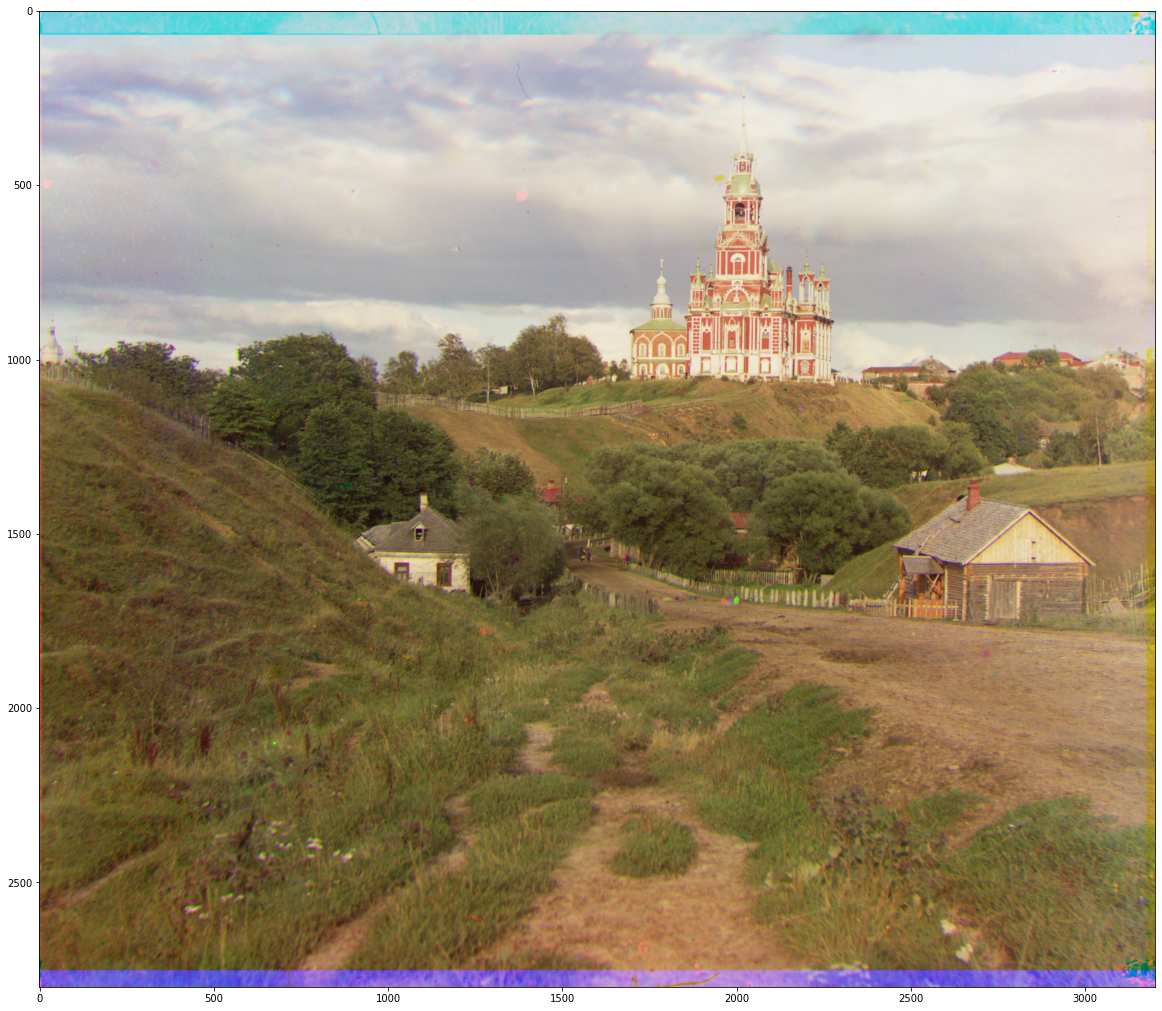

In [95]:
test_number = (1, 2)
img = img_as_ubyte(imread(f'public_tests/{test_number[0]}{test_number[1]}_test_img_input/img.png'))
colored_img, h = compute_colored_img(img)
cropped_img = crop_colored_img(colored_img)
print('cropped_shape ', cropped_img.shape)

# correct answer

parts = open(f'public_tests/{test_number[0]}{test_number[1]}_test_img_gt/gt.csv').read().rstrip('\n').split(',')
gt = {
    'r': (int(parts[5]), int(parts[6])),
    'g': (int(parts[3]), int(parts[4])),
    'b': (int(parts[1]), int(parts[2])),
}

#correct shift

gs = {
    'r': (gt['g'][0] - gt['r'][0] + h, gt['g'][1] - gt['r'][1]),
    'b': (gt['g'][0] - gt['b'][0] - h, gt['g'][1] - gt['b'][1]),
}
print(f'gt: {gt}\ngs: {gs}')


# correct img

res_img = colored_by_shift(cropped_img[:, :, 1], cropped_img[:, :, 2], cropped_img[:, :, 0], gs['b'], gs['r'])
plot(res_img, (20, 20))

In [100]:
# Я не знаю почему
# решение проходит все тесты
# И берет полный балл
# Но здесь картинка кривая :(

big
(7392, 2237) (974, 2378)


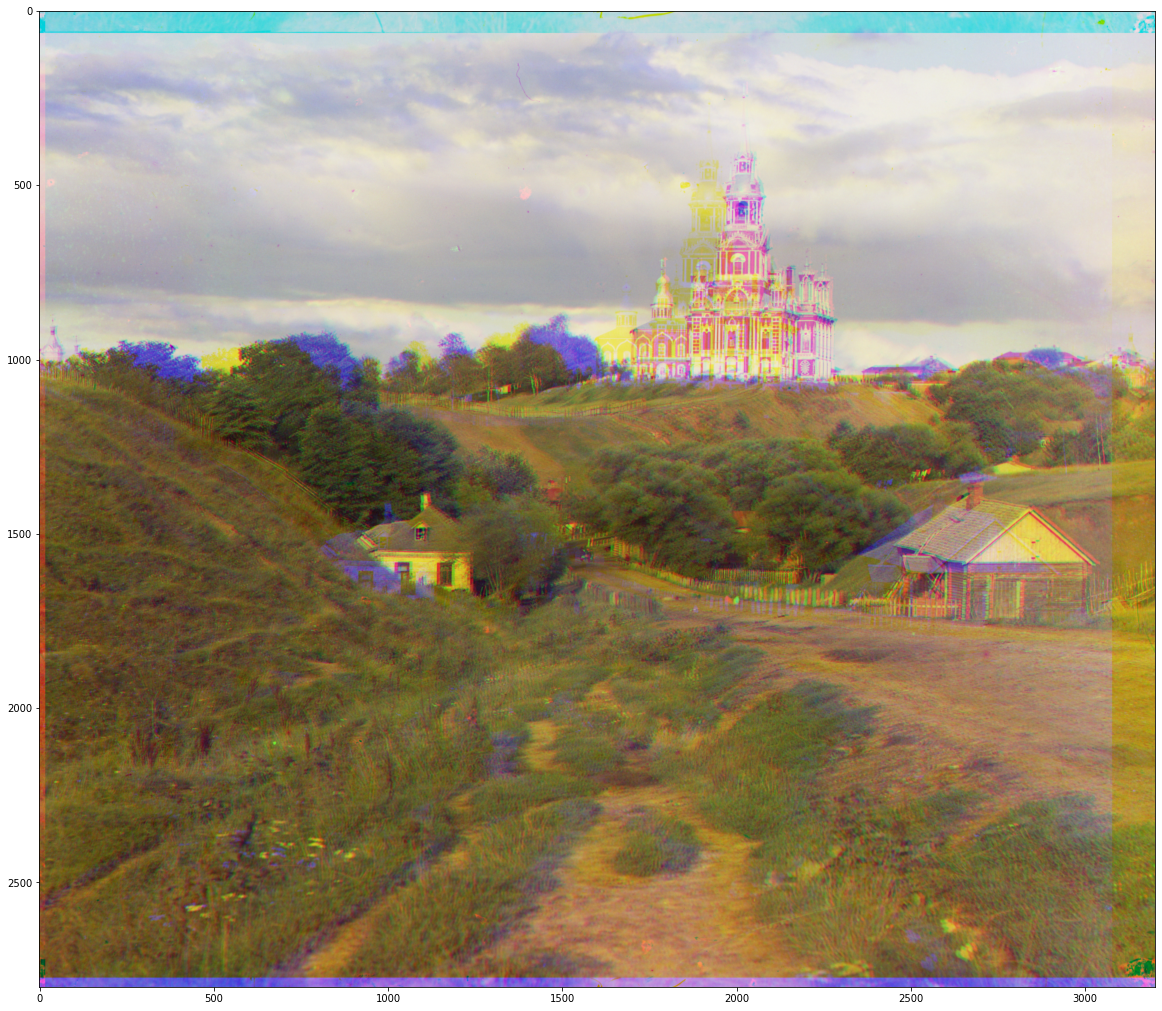

In [96]:
# my solution

res_img, b_coord, r_coord = align(img, gt['g'])
print(r_coord, b_coord)
plot(res_img, (20, 20))

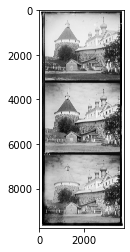

In [90]:
plot(img)

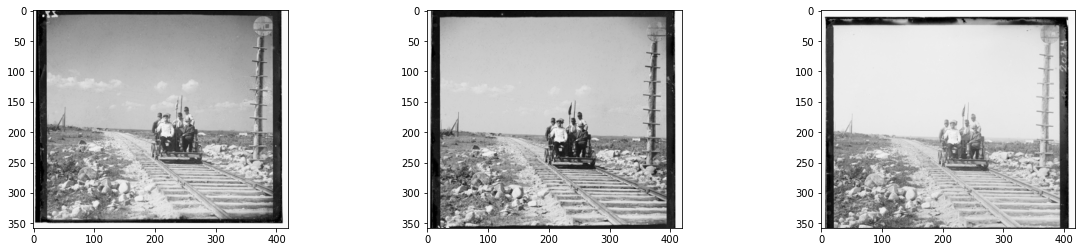

In [23]:
plot3(colored_img)

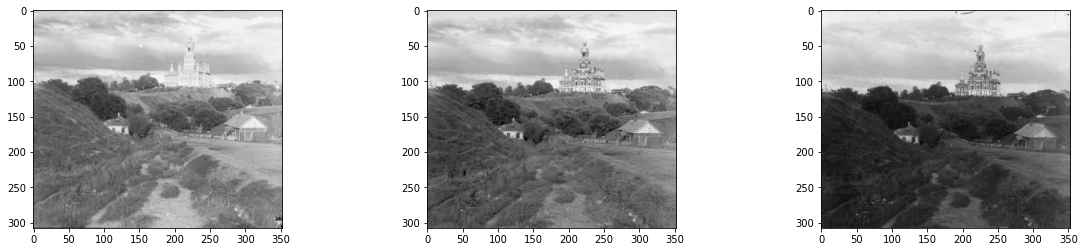

In [11]:
plot3(cropped_img)

In [13]:
shift_range = 15
xv, yv = np.meshgrid(np.arange(-shift_range, shift_range), np.arange(-shift_range, shift_range))
shifts = np.stack((xv.ravel(), yv.ravel())).T

In [138]:
mses_r = np.array([compute_mse_with_shift(cropped_img[:, :, 1], cropped_img[:, :, 0], tuple(shift)) for shift in shifts])
best_r_shift = shifts[mses_r.argmin()]
best_r_shift

array([ 8, -1])

In [139]:
mses_b = np.array([compute_mse_with_shift(cropped_img[:, :, 1], cropped_img[:, :, 2], tuple(shift)) for shift in shifts])
best_b_shift = shifts[mses_b.argmin()]
best_b_shift

array([-3,  1])

In [140]:
mses_r = np.array([compute_ncc_with_shift(cropped_img[:, :, 1], cropped_img[:, :, 0], tuple(shift)) for shift in shifts])
best_r_shift = shifts[mses_r.argmax()]
best_r_shift

array([0, 0])

In [141]:
mses_b = np.array([compute_ncc_with_shift(cropped_img[:, :, 1], cropped_img[:, :, 2], tuple(shift)) for shift in shifts])
best_b_shift = shifts[mses_b.argmax()]
best_b_shift

array([0, 0])

In [142]:
def g_to_b(row, col):
    return row - h + best_b_shift[0], col + best_b_shift[1]
def g_to_r(row, col):
    return row + h + best_r_shift[0], col + best_r_shift[1]


g_to_b(386,134,), g_to_r(386,134)

((28, 134), (744, 134))

In [144]:
res_img = colored_by_shift(cropped_img[:, :, 1], cropped_img[:, :, 2], cropped_img[:, :, 0], best_b_shift, best_r_shift)
res_img.shape

(316, 369, 3)

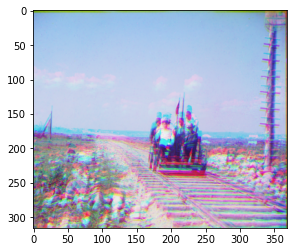

In [145]:
plot(cropped_img)

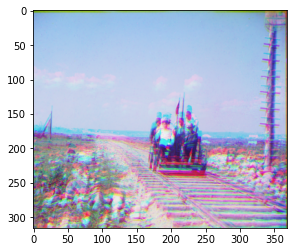

In [146]:
plot(res_img)

In [60]:
shifts_4 = compute_shifts(4)
b_shift_8 = (200, 100)

In [61]:
int_mul_tuple(2, b_shift_8)

(400, 200)